<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S13_AssignmentSolution/EVA13_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vit-pytorch linformer

     |████████████████████████████████| 50 kB 2.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# loading Libraries

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

In [4]:
# import Linformer

from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

In [5]:
# import torch and related libraries 

import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   
#sklearn to split the data

from sklearn.model_selection import train_test_split 

In [35]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 5
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [7]:
#Load data
base_path = '/content/gdrive/MyDrive/dogsvscats'
# os.makedirs('data', exist_ok=True)
train_path = os.path.join(base_path,'train.zip')
test_path = os.path.join(base_path,'test.zip')

In [8]:
train_dir = os.path.join(base_path,'train')
test_dir = os.path.join(base_path,'test')
train_dir,test_dir

('/content/gdrive/MyDrive/dogsvscats/train',
 '/content/gdrive/MyDrive/dogsvscats/test')

In [21]:
# #Unzipping dataset
with zipfile.ZipFile(train_path) as train_zip:
    train_zip.extractall(base_path)

In [18]:
with zipfile.ZipFile(test_path) as test_zip:
    test_zip.extractall(base_path)

In [22]:
#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [23]:
#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [41]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]
print(labels)

['dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat'

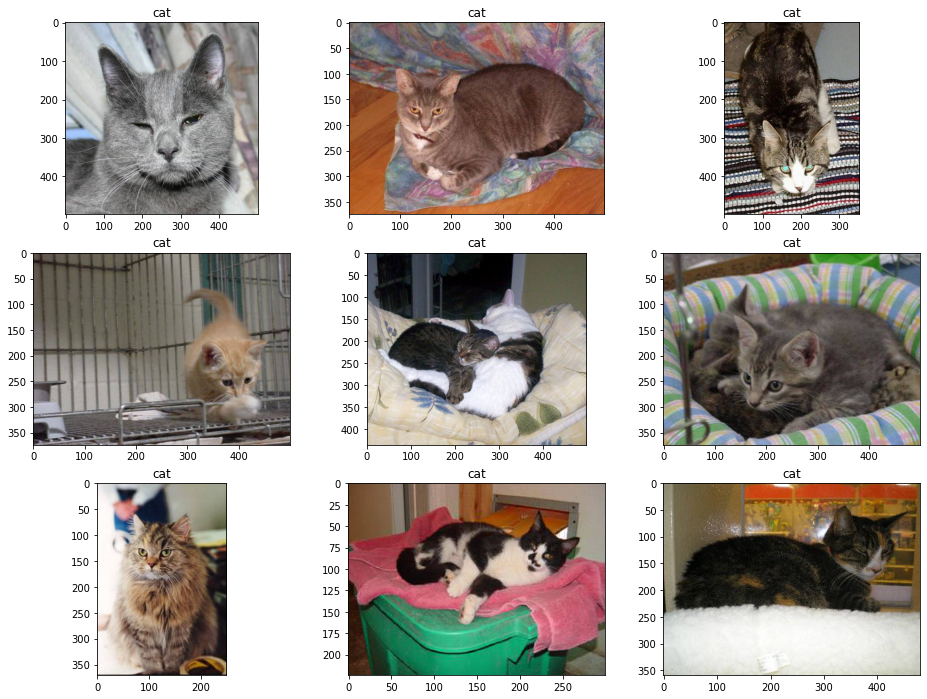

In [25]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [26]:
#Splitting train and validation list
seed = 42
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [27]:
# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [28]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [29]:
#defining train, validation and test dataset

train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [30]:
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [31]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [33]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [34]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [36]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6969 - acc: 0.5048 - val_loss : 0.6916 - val_acc: 0.5423



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6923 - acc: 0.5189 - val_loss : 0.6878 - val_acc: 0.5459



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6862 - acc: 0.5486 - val_loss : 0.6779 - val_acc: 0.5718



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6726 - acc: 0.5807 - val_loss : 0.6676 - val_acc: 0.5941



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6634 - acc: 0.5918 - val_loss : 0.6670 - val_acc: 0.5874



In [39]:
# testing
for i,(images,labels) in enumerate(test_loader):
  images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
  outputs = model(images) # (1, 1000)
  preds = outputs.argmax(dim=1, keepdim=True).squeeze(1)
  print(labels,preds)
  break



tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
